In [1]:
import pandas as pd
import numpy as np
from config import *
from importlib import reload
import helpers as hp
reload(hp)
import matplotlib.pyplot as plt
from config import *
import pickle
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from skopt import BayesSearchCV, space
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
from sklearn.metrics import roc_auc_score, PrecisionRecallDisplay, RocCurveDisplay, precision_recall_curve
from sklearn.pipeline import Pipeline
from sklearn import clone
# from imblearn.pipeline import Pipeline as ImbalancedPipeline
from functools import partial
import gc

### Loading and splitting data

In [2]:
df = pd.read_csv(DF_TRAIN_FILE_PATH, 
                 dtype=DATA_CAST_DICT, index_col=INDEX
)

df = hp.clean_rows(df)
df.head()

,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
UniqueID,,,,,,,,,,,,,,,,,,,,,
420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [3]:
X = df.drop(LABEL, axis=1)
y = df[LABEL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED, stratify=y)

pipe_fpp = hp.make_full_preprocessing_pipeline().set_output(transform="pandas")
# This classifier is used for basic model trainig
adaboost_400estimators = hp.CustomAdaBoostClassifier(n_estimators=400, **PLAIN_ADABOOST_PARAMS)

del df
gc.collect();

### Basic model training

#### <b>AdaBoost</b> | 400 estimators | X_train 50_000 sample

CustomAdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                         n_estimators=400, random_state=2023)

Performances | basic model trained on 50_000 sample of X_train
==============================Train set==============================
Accuracy: 0.783
Precision: 0.563
Recall: 0.028
F1: 0.053
AUC: 0.67785925

Confusion Matrix:


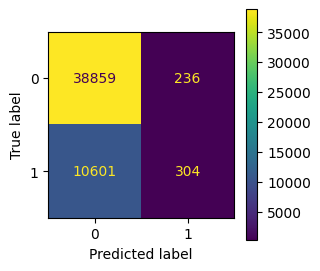

==============================Test set==============================
Accuracy: 0.781
Precision: 0.424
Recall: 0.021
F1: 0.04
AUC: 0.6447272

Confusion Matrix:


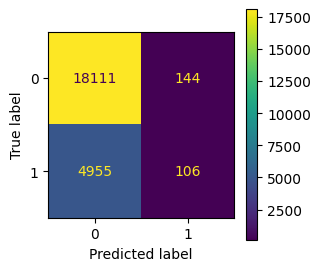

In [4]:
X_train_sample = X_train.sample(50_000, random_state=RANDOM_SEED)
y_train_sample = y_train.sample(50_000, random_state=RANDOM_SEED)

X_train_sample_t = pipe_fpp.fit_transform(X_train_sample)
X_test_t = pipe_fpp.transform(X_test)

# Deleting 'variables' that'll no longer be used
del X_train_sample
gc.collect()

(_,
y_train_sample_hat_proba,
_,
y_test_hat_proba,
train_test_sample_estimator) = hp.train_test_custom(adaboost_400estimators, X_train_sample_t, X_test_t, y_train_sample, y_test, return_estimator=True).values()

display(train_test_sample_estimator)

del X_train_sample_t, X_test_t
gc.collect()

print("Performances | basic model trained on 50_000 sample of X_train")
print(30*"=" + "Train set" + 30*"=")
hp.print_performances(y_train_sample, y_train_sample_hat_proba)
print(30*"=" + "Test set" + 30*"=")
hp.print_performances(y_test, y_test_hat_proba)

# Saving pipeline
with open("models/adaboost_400estimators_50000sample.pickle", "wb") as file:
    pickle.dump(train_test_sample_estimator, file)

del y_train_sample_hat_proba, y_test_hat_proba, train_test_sample_estimator, file
gc.collect();

#### <b>AdaBoost</b> | 400 estimators | X_train

Performances | basic model trained on X_train
==============================Train set==============================
Accuracy: 0.783
Precision: 0.513
Recall: 0.019
F1: 0.037
AUC: 0.66453771

Confusion Matrix:


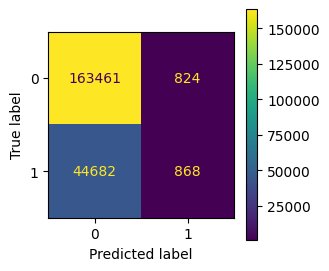

==============================Test set==============================
Accuracy: 0.783
Precision: 0.49
Recall: 0.019
F1: 0.036
AUC: 0.65948897

Confusion Matrix:


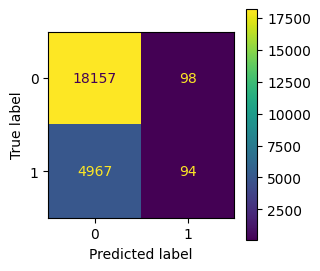

In [5]:
X_train_t = pipe_fpp.fit_transform(X_train)
X_test_t = pipe_fpp.transform(X_test)

(_,
y_train_hat_proba,
_,
y_test_hat_proba,
train_test_estimator) = hp.train_test_custom(adaboost_400estimators, X_train_t, X_test_t, y_train, y_test, return_estimator=True).values()

del X_train_t, X_test_t
gc.collect()

print("Performances | basic model trained on X_train")
print(30*"=" + "Train set" + 30*"=")
hp.print_performances(y_train, y_train_hat_proba)
print(30*"=" + "Test set" + 30*"=")
hp.print_performances(y_test, y_test_hat_proba)

# Saving pipeline
with open("models/adaboost_400estimators_alldata.pickle", "wb") as file:
    pickle.dump(train_test_estimator, file)

del y_train_hat_proba, y_test_hat_proba, train_test_estimator, file
gc.collect();

### Learning curves

#### Learning curve - Train set size

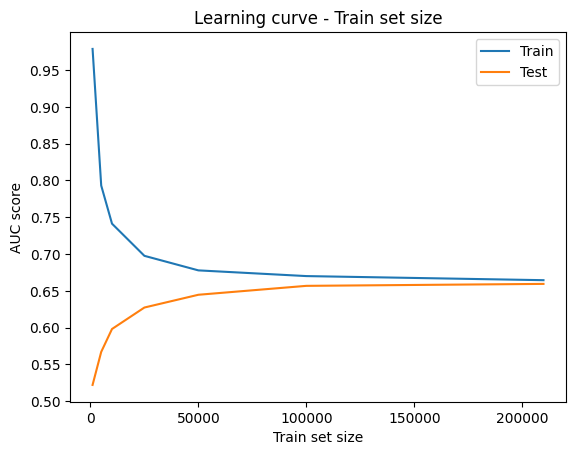

In [6]:
train_sizes = [1_000, 5_000, 10_000, 25_000, 50_000, 100_000, X_train.shape[0]]

lc_train_size_data = hp.perform_learning_curve_train_sizes(adaboost_400estimators, pipe_fpp, X_train, X_test, y_train, y_test, train_sizes, n_jobs=-1)

test_auc_scores = []
train_auc_scores = []

for a in lc_train_size_data:
    a: dict = list(a.values())[0]
    train_auc_scores.append(roc_auc_score(a["y_train"], a["y_train_hat_proba"][:, 1]))
    test_auc_scores.append(roc_auc_score(a["y_test"], a["y_test_hat_proba"][:, 1]))

# AdaBoost with 400 estimators
plt.plot(train_sizes, train_auc_scores, label="Train")
plt.plot(train_sizes, test_auc_scores, label="Test")
plt.legend()
plt.xlabel("Train set size")
plt.ylabel("AUC score")
plt.yticks(np.arange(0.5, 1.0, 0.05))
plt.title("Learning curve - Train set size")
plt.show()

del train_sizes, train_auc_scores, test_auc_scores, a, adaboost_400estimators
gc.collect();

#### Learning curve - n_estimators (hyperparam)

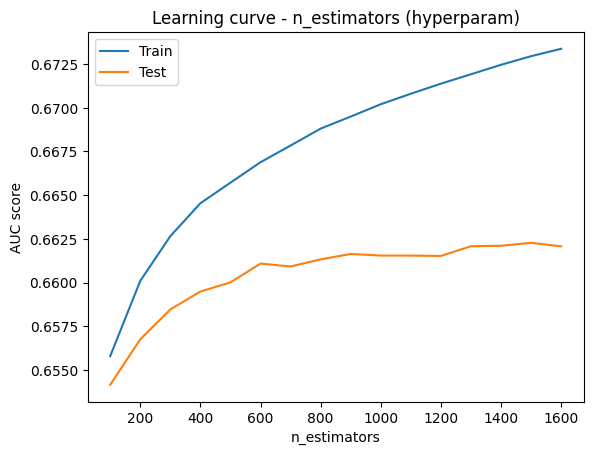

In [7]:
n_estimators_hyperparam = {"n_estimators": np.arange(100, 1601, 100)}

X_train_t = pipe_fpp.fit_transform(X_train)
X_test_t = pipe_fpp.transform(X_test)

lc_n_estimators_data = hp.perform_learning_curve_hyperparameter(hp.CustomAdaBoostClassifier(**PLAIN_ADABOOST_PARAMS), 
                                                                X_train_t, X_test_t, y_train, y_test, n_estimators_hyperparam, n_jobs=-1)
train_auc_scores = []
test_auc_scores = []

for a in lc_n_estimators_data:
    a: dict = list(a.values())[0]
    train_auc_scores.append(roc_auc_score(a["y_train"], a["y_train_hat_proba"][:, 1]))
    test_auc_scores.append(roc_auc_score(a["y_test"], a["y_test_hat_proba"][:, 1]))

plt.plot(n_estimators_hyperparam["n_estimators"], train_auc_scores, label="Train")
plt.plot(n_estimators_hyperparam["n_estimators"], test_auc_scores, label="Test")
plt.legend()
plt.xlabel("n_estimators")
plt.ylabel("AUC score")
plt.title("Learning curve - n_estimators (hyperparam)")
plt.show()

del n_estimators_hyperparam, X_train_t, X_test_t, test_auc_scores, train_auc_scores
gc.collect();

### Hyperparameter tuning

#### Making pipeline

In [8]:
fs_name = 'mutualinfoclassif'
classifier_name = 'AdaBoost'

# pipe_fpp is already defined earlier
mutual_info_classif_partial = partial(mutual_info_classif, random_state=RANDOM_SEED)
fs = SelectKBest(score_func=mutual_info_classif_partial).set_output(transform="pandas")
classifier = hp.CustomAdaBoostClassifier(**PLAIN_ADABOOST_PARAMS)

pipe_train = Pipeline([])

for step_name, step in pipe_fpp.named_steps.items():
    pipe_train.steps.append((step_name, step))

pipe_train.steps.extend([
    (fs_name, fs),
    (classifier_name, classifier)
])

# Define search space of hyperparameters for Bayes search
param_space = {
    f'{fs_name}__k': space.Integer(13, 44),
    f'{classifier_name}__learning_rate': space.Real(10**-3, 10**0, prior="log-uniform"),
    f'{classifier_name}__n_estimators': space.Integer(900, 1700),
    f'{classifier_name}__minority_class_weight': space.Real(1, 5)
}

cv = StratifiedKFold(n_splits=CV_SPLIT_SIZE, shuffle=True, random_state=RANDOM_SEED)

# Callback handler
def on_step(optim_result):  
    n_iter = len(optim_result['func_vals'])
    current_auc_score = -optim_result['func_vals'][n_iter-1]
    best_auc_score = -optim_result['fun']
    
    print(f"iter {n_iter}. AUC score: {current_auc_score}")
    print(f"Best AUC score: {best_auc_score}")
    print()

#### BayesSearchCV (tuning all hyperparameters except the split criterion for the AdaBoost estimator)

In [9]:
bayessearchcv = BayesSearchCV(
    pipe_train,
    param_space,
    scoring="roc_auc",
    n_iter=30,
    cv=cv,
    n_jobs=-1,
    random_state=RANDOM_SEED,
    verbose=10
)

print(f"Starting Bayesian search hyperparameter tuning (without split criterion)...")
bayessearchcv.fit(X_train, y_train, callback=on_step)
print(f"Finished Bayesian search hyperparameter tuning (without split criterion).")

Starting Bayesian search hyperparameter tuning (without split criterion)...
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[CV 1/5; 1/1] START AdaBoost__learning_rate=0.3628326141162967, AdaBoost__minority_class_weight=1.7803979140448953, AdaBoost__n_estimators=1191, mutualinfoclassif__k=20
[CV 5/5; 1/1] START AdaBoost__learning_rate=0.3628326141162967, AdaBoost__minority_class_weight=1.7803979140448953, AdaBoost__n_estimators=1191, mutualinfoclassif__k=20
[CV 2/5; 1/1] START AdaBoost__learning_rate=0.3628326141162967, AdaBoost__minority_class_weight=1.7803979140448953, AdaBoost__n_estimators=1191, mutualinfoclassif__k=20
[CV 4/5; 1/1] START AdaBoost__learning_rate=0.3628326141162967, AdaBoost__minority_class_weight=1.7803979140448953, AdaBoost__n_estimators=1191, mutualinfoclassif__k=20
[CV 3/5; 1/1] START AdaBoost__learning_rate=0.3628326141162967, AdaBoost__minority_class_weight=1.7803979140448953, AdaBoost__n_estimators=1191, mutualinfoclassif__k=20
[CV 3/5; 1/1] END AdaBoost__learning_rate=0.3628326141162967, AdaBoost__minority_class_weight=1.7803979140448953, AdaBoost__n_estimators=1191, mutualinfocl

In [10]:
best_model_bs = bayessearchcv.best_estimator_
best_auc_bs = bayessearchcv.best_score_
best_model_hyperparameters_bs = dict(bayessearchcv.best_params_)

print(30*"=" + "Bayes search results" + 30*"=")
print(f"Best AUC score: {best_auc_bs}")
print("Best hyperparameters:")
for k, v in best_model_hyperparameters_bs.items():
    print(f"'{k}': {v}")

del k, v;

==============================Bayes search results==============================
Best AUC score: 0.6588799199618531
Best hyperparameters:
'AdaBoost__learning_rate': 0.8025709588736879
'AdaBoost__minority_class_weight': 5.0
'AdaBoost__n_estimators': 1700
'mutualinfoclassif__k': 42


#### Bayes search plots

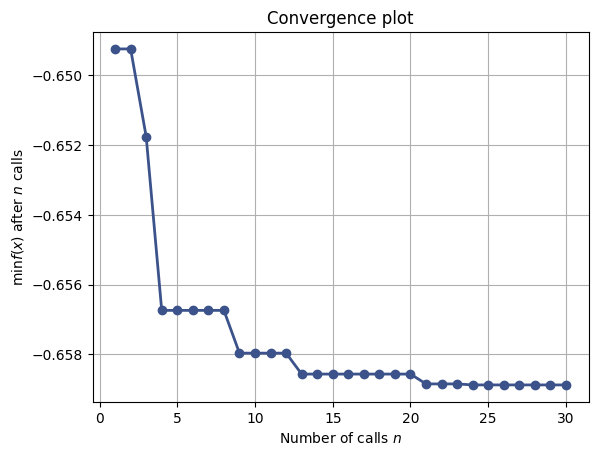

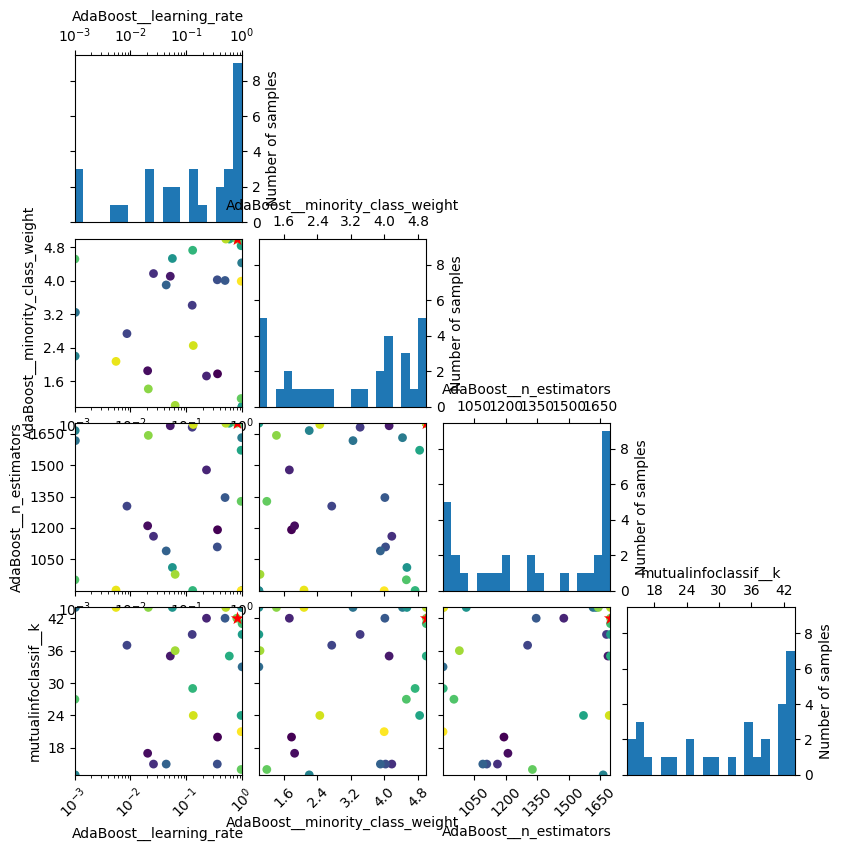

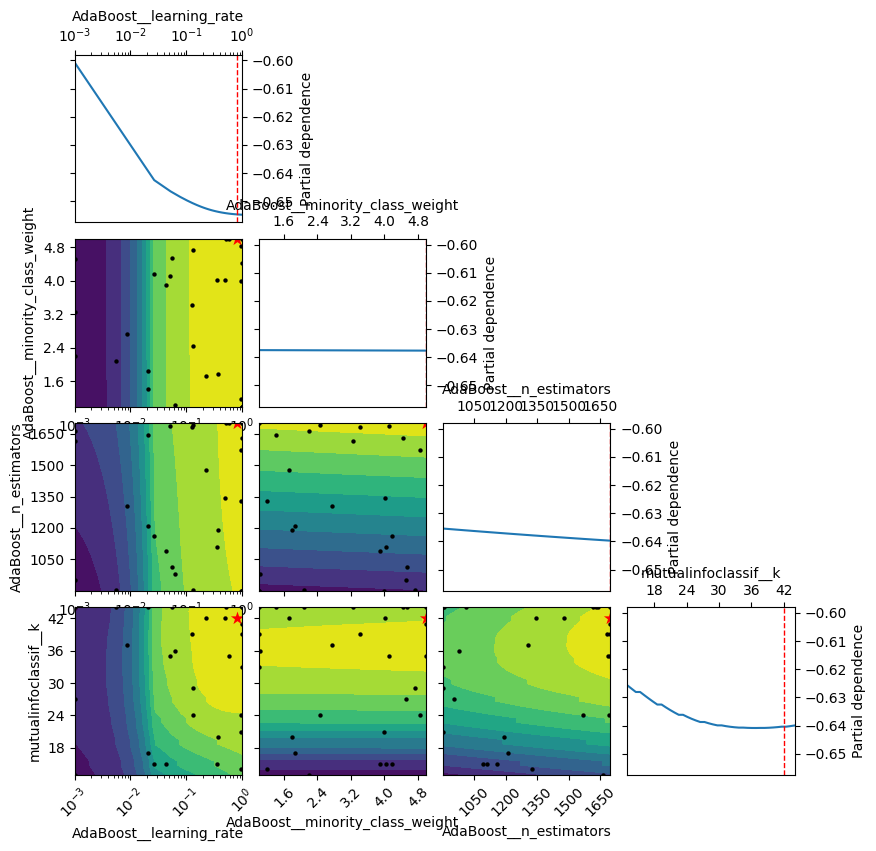

In [11]:
plot_convergence(bayessearchcv.optimizer_results_[0])
plot_evaluations(bayessearchcv.optimizer_results_[0])
plot_objective(bayessearchcv.optimizer_results_[0]);

#### GridSearchCV (tuning 'criterion' for the base estimator of AdaBoost)

In [12]:
param_criterion_dict = {f"{classifier_name}__estimator__criterion": ["gini", "entropy"]}

gridsearchcv = GridSearchCV(best_model_bs,
    param_criterion_dict,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    refit=True,
    verbose=10,
)

print(f"Starting Grid search hyperparameter tuning for split criterion...")
gridsearchcv.fit(X_train, y_train)

print()
print(f"Finished Grid search hyperparameter tuning for split criterion.")
print("Finished all hyperparameter tuning.")

Starting Grid search hyperparameter tuning for split criterion...
Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 2/5; 1/2] START AdaBoost__estimator__criterion=gini.........................
[CV 4/5; 1/2] START AdaBoost__estimator__criterion=gini.........................
[CV 3/5; 1/2] START AdaBoost__estimator__criterion=gini.........................
[CV 1/5; 1/2] START AdaBoost__estimator__criterion=gini.........................
[CV 5/5; 1/2] START AdaBoost__estimator__criterion=gini.........................
[CV 1/5; 2/2] START AdaBoost__estimator__criterion=entropy......................
[CV 3/5; 2/2] START AdaBoost__estimator__criterion=entropy......................
[CV 2/5; 2/2] START AdaBoost__estimator__criterion=entropy......................
[CV 4/5; 1/2] END AdaBoost__estimator__criterion=gini;, score=0.656 total time=29.5min
[CV 4/5; 2/2] START AdaBoost__estimator__criterion=entropy......................
[CV 5/5; 1/2] END AdaBoost__estimator__criterion=gini;, sc

In [13]:
best_model_gs = gridsearchcv.best_estimator_
best_auc_gs = gridsearchcv.best_score_
best_model_hyperparameters_gs = dict(gridsearchcv.best_params_)

print(30*"=" + "Grid search results" + 30*"=")
print(f"Best AUC score: {best_auc_gs}")
print(f"Best split criterion: {list(best_model_hyperparameters_gs.values())[0]}")

==============================Grid search results==============================
Best AUC score: 0.6588799199618531
Best split criterion: gini


#### Best hyperparameters

In [14]:
best_auc_X_train = best_auc_gs
best_model_X_train = best_model_gs
best_model_hyperparameters = best_model_hyperparameters_bs.copy()
best_model_hyperparameters.update(best_model_hyperparameters_gs)

print(30*"=" + "Hyperparameter tuning results" + 30*"=")
print(f"Best AUC score: {best_auc_X_train}")
print("Best hyperparameters:")
for k, v in best_model_hyperparameters.items():
    print(f"'{k}': {v}")

del k, v
gc.collect();

==============================Hyperparameter tuning results==============================
Best AUC score: 0.6588799199618531
Best hyperparameters:
'AdaBoost__learning_rate': 0.8025709588736879
'AdaBoost__minority_class_weight': 5.0
'AdaBoost__n_estimators': 1700
'mutualinfoclassif__k': 42
'AdaBoost__estimator__criterion': gini


#### Feature importances

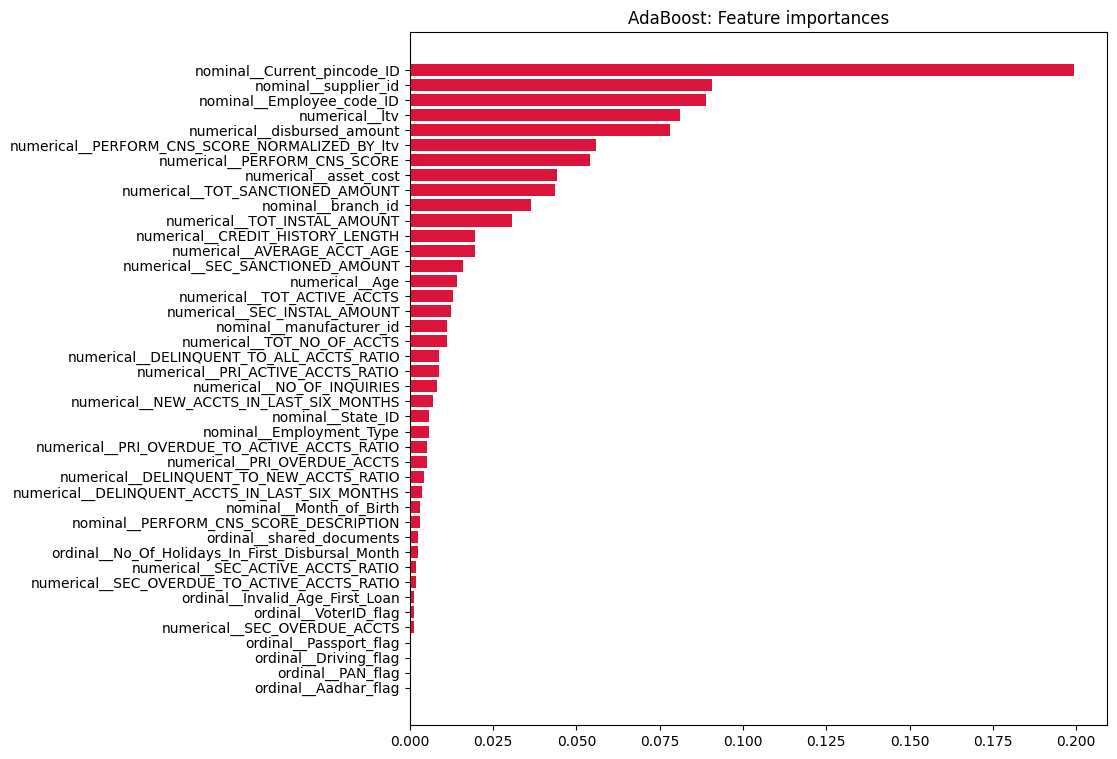

In [15]:
_, ax = plt.subplots(figsize=(9, 9))

feat_import_dict = {k: v for k, v in zip(best_model_X_train[classifier_name].feature_names_in_, 
                                         best_model_X_train[classifier_name].feature_importances_)}

# Sort dictionary by importances (descending)
feat_import_dict = dict(sorted(feat_import_dict.items(), key=lambda x: x[1], reverse=False))
ax.barh(list(feat_import_dict.keys()), list(feat_import_dict.values()), color="crimson")
ax.set_title(f"{classifier_name}: Feature importances")
plt.show()

del ax;

### Performances on train data (default decision threshold)

#### Accuracy, Precision, Recall, F1, AUC, Confusion Matrix

Performances (default decision threshold) | model trained on X_train
==============================Train set==============================
Accuracy: 0.489
Precision: 0.274
Recall: 0.824
F1: 0.412
AUC: 0.67144408

Confusion Matrix:


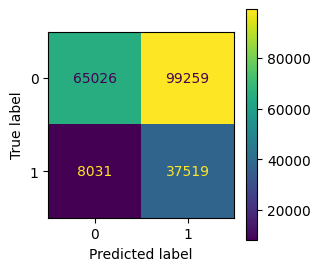

==============================Test set==============================
Accuracy: 0.482
Precision: 0.271
Recall: 0.817
F1: 0.407
AUC: 0.66301724

Confusion Matrix:


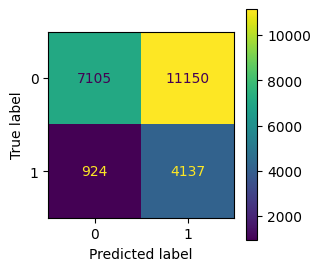

In [16]:
# predict_proba on X_train & X_test (best_model is already fit on all df_train because refit=True in GridSearchCV)
y_train_pred_proba = best_model_X_train.predict_proba(X_train)
y_test_pred_proba = best_model_X_train.predict_proba(X_test)

print("Performances (default decision threshold) | model trained on X_train")
print(30*"=" + "Train set" + 30*"=")
hp.print_performances(y_train, y_train_pred_proba)
print(30*"=" + "Test set" + 30*"=")
hp.print_performances(y_test, y_test_pred_proba)

#### ROC and PrecisionRecall curve

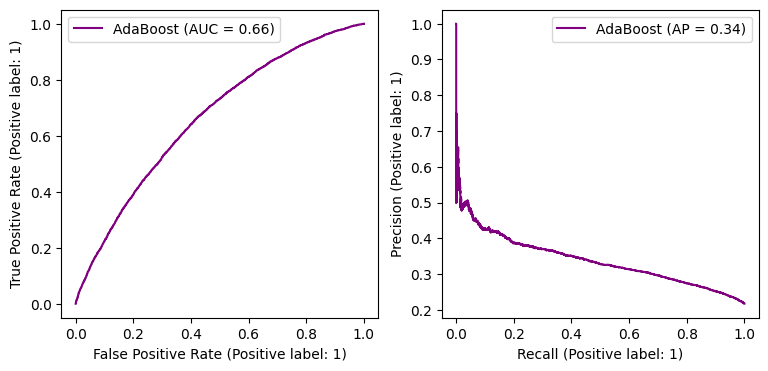

In [17]:
_, ax = plt.subplots(1, 2, figsize=(9, 4))

RocCurveDisplay.from_predictions(y_test, y_test_pred_proba[:, 1], name=classifier_name, ax=ax[0])
PrecisionRecallDisplay.from_predictions(y_test, y_test_pred_proba[:, 1], name=classifier_name, ax=ax[1]);

# Set line color to purple and reset legend so the color on it is displayed properly
for ax_ in ax:
    ax_.get_lines()[0].set_color("purple")
    ax_.legend()

del ax_

### Optimizing decision threshold

In [18]:
precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred_proba[:, 1])
f1_scores = 2 * precision * recall / (precision + recall)
best_threshold = thresholds[np.nanargmax(f1_scores)]

print(f'Best threshold: {best_threshold}')
print(f'Best F1 score: {np.nanmax(f1_scores)}')

Best threshold: 0.500054902962931
Best F1 score: 0.4176365539749984


### Performances on train data (optimized decision threshold)

Performances (optimized decision threshold) | model trained on X_train
==============================Train set==============================
Accuracy: 0.598
Precision: 0.306
Recall: 0.671
F1: 0.42
AUC: 0.67144408

Confusion Matrix:


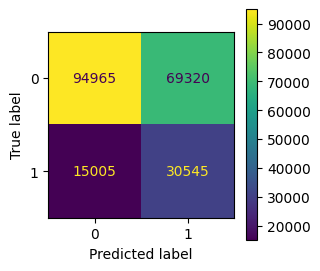

==============================Test set==============================
Accuracy: 0.594
Precision: 0.303
Recall: 0.67
F1: 0.418
AUC: 0.66301724

Confusion Matrix:


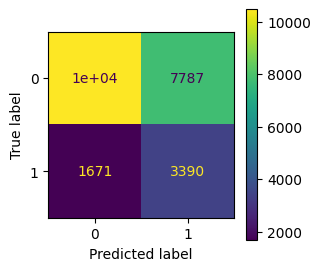

In [19]:
print("Performances (optimized decision threshold) | model trained on X_train")
print(30*"=" + "Train set" + 30*"=")
hp.print_performances(y_train, y_train_pred_proba, threshold=best_threshold)
print(30*"=" + "Test set" + 30*"=")
hp.print_performances(y_test, y_test_pred_proba, threshold=best_threshold)

### Train model on all data

In [20]:
best_model_X = clone(best_model_X_train)
best_model_X.fit(X, y)

y_train_pred_proba_X = best_model_X.predict_proba(X)

### Performances on all data

Performances (optimized decision threshold) | model trained on X
==============================Train set==============================
Accuracy: 0.598
Precision: 0.306
Recall: 0.67
F1: 0.42
AUC: 0.67069184

Confusion Matrix:


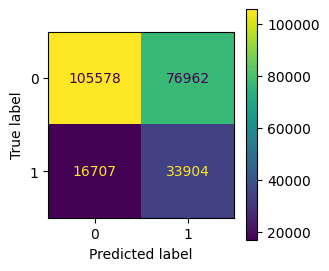

In [21]:
print("Performances (optimized decision threshold) | model trained on X")
print(30*"=" + "Train set" + 30*"=")
hp.print_performances(y, y_train_pred_proba_X, threshold=best_threshold)

### Saving best models

#### Trained on X_train

In [22]:
with open("models/adaboost_best_X_train.pickle", "wb") as file:
    pickle.dump(best_model_X_train, file)
del file

#### Trained on X

In [23]:
with open("models/adaboost_best_X.pickle", "wb") as file:
    pickle.dump(best_model_X, file)

del file
# # Load best model
# with open("models/adaboost_best_X.pickle", "rb") as file:
#     best_model = pickle.load(file)

### Creating predictions for test.csv and submitting results

In [24]:
df_test = pd.read_csv(DF_TEST_FILE_PATH, 
                 dtype=DATA_CAST_DICT
)

df_test.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES
0,655269,53478,63558,86.54,67,22807,45,1497,01-01-74,Salaried,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
1,723482,55513,63163,89.45,67,22807,45,1497,20-05-85,Self employed,...,0,0,0,5605,0,1,0,0yrs 8mon,1yrs 0mon,1
2,758529,65282,84320,79.93,78,23135,86,2071,14-10-95,Salaried,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0
3,763449,46905,63896,76.58,78,17014,45,2070,01-06-73,Self employed,...,0,0,0,0,0,0,0,2yrs 5mon,2yrs 5mon,0
4,708663,51428,63896,86.08,78,17014,45,2069,01-06-72,Salaried,...,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0


In [25]:
df_test['DisbursalDate']

0         03-11-18
1         20-11-18
2         29-11-18
3         29-11-18
4         17-11-18
            ...   
112387    28-11-18
112388    19-11-18
112389    17-11-18
112390    15-11-18
112391    28-11-18
Name: DisbursalDate, Length: 112392, dtype: object

In [26]:
y_subm_pred = best_model_X.predict(df_test)

submission = pd.DataFrame(
    {
        'UniqueID': df_test['UniqueID'],
        'loan_default': y_subm_pred
    }
)

submission[LABEL].value_counts()

1    72746
0    39646
Name: loan_default, dtype: int64

In [27]:
submission.to_csv("submission.csv", index=False)